In [6]:
from cycle_ratio import CycleRatio, read_graph, node_edge_count
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
import networkx as nx
from tqdm import tqdm
import json
import random
from matplotlib.backends.backend_pdf import PdfPages
import networkx as nx


cycle_ratio = {}
degree_ratio = {}
coreness_ratio = {}
h_index_ratio = {}

indices_performance = {}

datasets = {'Celegans.txt': True, 'Email.txt': True, 'Jazz.txt': False, 'NS_GC.txt': False, 'USAir.txt': True, 'Yeast.txt': False}

In [7]:
def hindex(g, n):
    sorted_neighbor_degrees = sorted(
        (g.degree(v) for v in g.neighbors(n)), reverse=True)
    h = 0
    for i in range(1, len(sorted_neighbor_degrees)+1):
        if sorted_neighbor_degrees[i-1] < i:
            break
        h = i
    return h


def node_importance_sorter(node_ratio: list):
    node_ratio = sorted(node_ratio.items(), key=lambda x: x[1], reverse=True)
    return [node for node, ratio in node_ratio]


def node_perculation(graph: nx.Graph, sorted_nodes: list):
    pointer = 0
    N = graph.number_of_nodes()
    try:
        connected_components = list(nx.weakly_connected_components(graph))
    except nx.exception.NetworkXNotImplemented:
        connected_components = list(nx.connected_components(graph))
    largest_component = max(connected_components, key=len)
    sub_graph = graph.subgraph(largest_component)
    g_n_track = [sub_graph.number_of_nodes()]

    with tqdm(total=len(sorted_nodes)) as pbar:
        while pointer < len(sorted_nodes):
            graph.remove_node(sorted_nodes[pointer])
            try:
                connected_components = list(nx.weakly_connected_components(graph))
            except nx.exception.NetworkXNotImplemented:
                connected_components = list(nx.connected_components(graph))
            if len(connected_components) > 0:
                largest_component = max(connected_components, key=len)
                sub_graph = graph.subgraph(largest_component)
                g_n_track.append(sub_graph.number_of_nodes())
            else:
                g_n_track.append(0)
            pointer += 1
            pbar.update(1)

    return [g_n/N for g_n in g_n_track]


def plot_perculation(g: list, color: str, facecolors: str, label: str):
    SKIP = int(len(g)*0.01)
    Y = g[::max(SKIP, 1)]
    X = np.arange(len(Y))/len(Y)
    plt.plot(X, Y, linestyle='-', color=color, zorder=1)
    plt.scatter(X, Y, marker='o', edgecolors=color, facecolors=facecolors, zorder=2, label=label)

Processing Celegans network


  0%|          | 0/297 [00:00<?, ?it/s]

100%|██████████| 297/297 [00:00<00:00, 9010.81it/s]


Processing Email network


100%|██████████| 1133/1133 [00:00<00:00, 2533.41it/s]


Processing Jazz network


100%|██████████| 198/198 [00:00<00:00, 9074.71it/s]


Processing NS_GC network


100%|██████████| 379/379 [00:00<00:00, 8082.91it/s]


Processing USAir network


100%|██████████| 332/332 [00:00<00:00, 8467.00it/s]


Processing Yeast network


100%|██████████| 2375/2375 [00:02<00:00, 850.31it/s] 


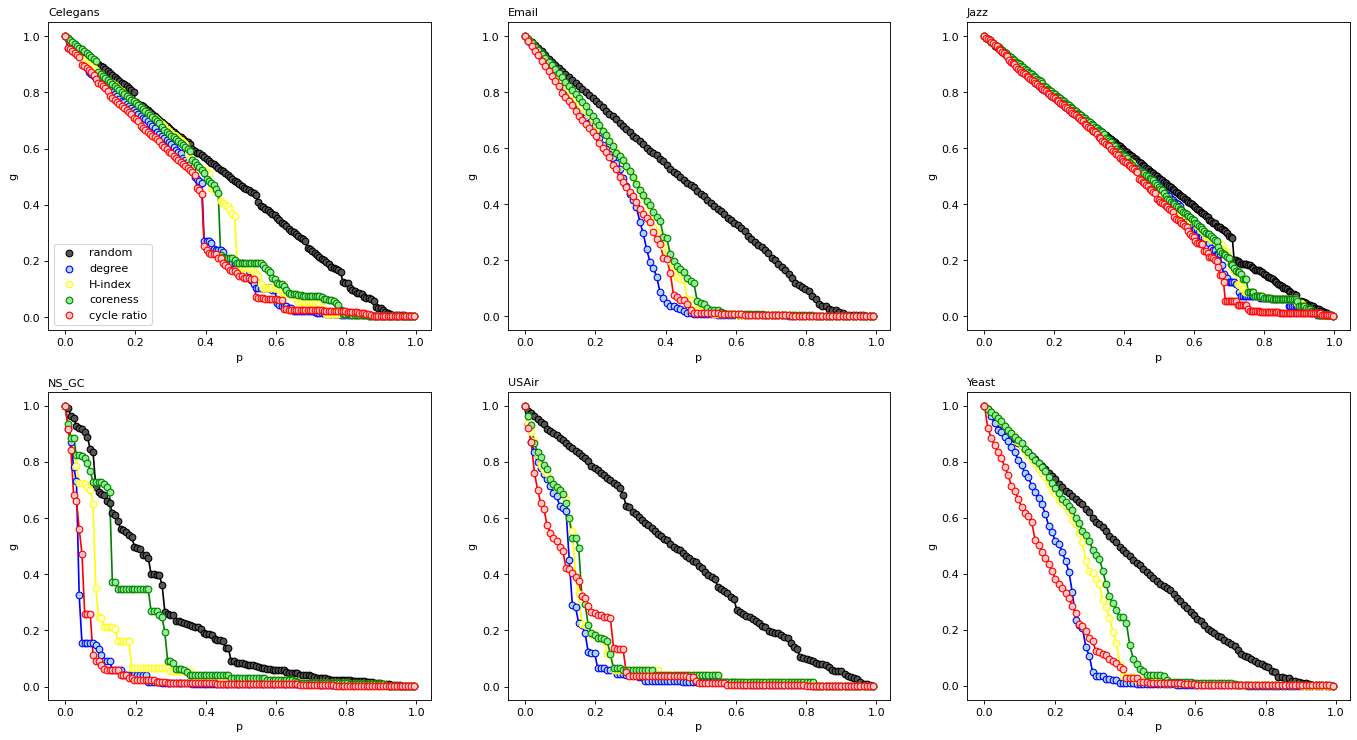

In [10]:

figure(figsize=(21, 11), dpi=80)
for index, network in enumerate(list(datasets.keys())):
    plt.subplot(2, 3, index+1)
    plt.title(network.split('.')[0],  fontsize=10,
                loc='left'), plt.xlabel('p'), plt.ylabel('g')

    network_name = network.split('.')[0]
    print(f'Processing {network_name} network')

    # Random Ratio
    graph = read_graph(f'Dataset/{network}')
    sorted_node_ratio = list(graph.nodes())
    random.shuffle(sorted_node_ratio)
    g_random = node_perculation(graph=graph, sorted_nodes=sorted_node_ratio)
    plot_perculation(g=g_random, color='black',facecolors='#555555', label='random')

    # Degree Ratio
    graph = read_graph(f'Dataset/{network}')
    degree_ratio_data = dict(graph.degree)
    sorted_node_ratio = node_importance_sorter(node_ratio=degree_ratio_data)
    g_degree = node_perculation(graph=graph, sorted_nodes=sorted_node_ratio)
    plot_perculation(g=g_degree, color='blue',facecolors='#ADD8E6', label='degree')

    # H-index Ratio
    graph = read_graph(f'Dataset/{network}')

    h_index_ratio_data = {}
    for node in list(graph.nodes):
        sorted_neighbor_degrees = sorted(
            (graph.degree(v) for v in graph.neighbors(node)), reverse=True)
        h = 0
        for i in range(1, len(sorted_neighbor_degrees)+1):
            if sorted_neighbor_degrees[i-1] < i:
                break
            h = i
        h_index_ratio_data[node] = h

    sorted_node_ratio = node_importance_sorter(node_ratio=h_index_ratio_data)
    g_hindex = node_perculation(graph=graph, sorted_nodes=sorted_node_ratio)
    plot_perculation(g=g_hindex, color='yellow',facecolors='#FFFFE0', label='H-index')

    # Coreness Ratio
    graph = read_graph(f'Dataset/{network}')
    coreness_ratio_data = nx.core_number(graph)
    sorted_node_ratio = node_importance_sorter(node_ratio=coreness_ratio_data)
    g_coreness = node_perculation(graph=graph, sorted_nodes=sorted_node_ratio)
    plot_perculation(g=g_coreness, color='green', facecolors='#90EE90', label='coreness')

    # Cycle Ratio base node
    graph = read_graph(f'Dataset/{network}')
    cr = CycleRatio(graph=graph)
    cr.prune_graph()
    cr.getSmallestCycles()
    cr.StatisticsAndCalculateIndicators(network=network_name)
    graph = read_graph(f'Dataset/{network}')
    sorted_node_ratio = node_importance_sorter(node_ratio=cr.CycleRatio)
    g_cycle = node_perculation(graph=graph, sorted_nodes=sorted_node_ratio)
    plot_perculation(g=g_cycle, color='red',facecolors='#FFCCCC', label='cycle ratio')

    indices_performance[network_name] = {
        'B': np.mean(g_random),
        'D': np.mean(g_degree),
        'H': np.mean(g_hindex),
        'C': np.mean(g_coreness),
        'R': np.mean(g_cycle),
    }
    if index == 0:
        plt.legend(loc='lower left', bbox_to_anchor=(0, 0))

<Figure size 640x480 with 0 Axes>

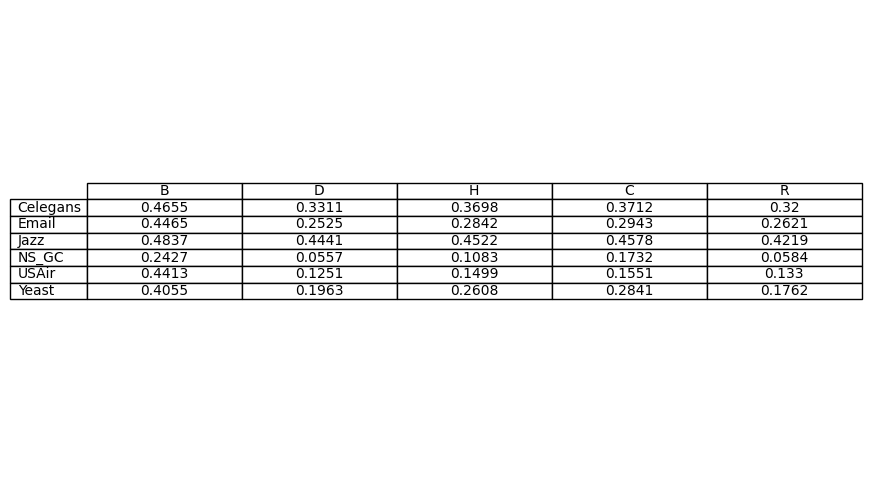

In [11]:
plt.savefig(f'node_perculation.jpg')
plt.show()

df = pd.DataFrame(indices_performance).T
for _, value in indices_performance.items():
    keys = value.keys()
    break
df.columns = list(keys)

fig, ax = plt.subplots(figsize=(10, 6))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

table = ax.table(cellText=df.round(4).values, colLabels=df.columns, rowLabels=df.index, cellLoc='center', loc='center')
with PdfPages('network_table.pdf') as pdf:
    pdf.savefig(fig, bbox_inches='tight')

plt.savefig(f'node_perculation_robustness.jpg')
plt.show()

with open("node_perculation.txt", "w") as f:
    f.write(json.dumps(indices_performance, indent=4))